## Chore App

##### Upload Libraries

In [3]:
import argparse
import json
import os
import time

import requests
import tqdm
from pexels_api import API
import numpy as np
import os
from dotenv import load_dotenv

import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils

from PIL import Image
import pillow_heif

##### Functions

In [ ]:
# Functions to upload images from Pexels.com

def decode_image(filename, image_type, resize_shape, channels):
    value = tf.io.read_file(filename)
    if image_type == 'png':
        decoded_image = tf.image.decode_png(value, channels=channels)
    elif image_type == 'jpeg':
        decoded_image = tf.image.decode_jpeg(value, channels=channels)
    else:
        decoded_image = tf.image.decode_image(value, channels=channels)
    
    if resize_shape is not None and image_type in ['png', 'jpeg']:
        decoded_image = tf.image.resize(decoded_image, resize_shape)
    
    return decoded_image

def get_dataset(image_paths, image_type, resize_shape, channels):
    filename_tensor = tf.constant(image_paths)
    dataset = tf.data.Dataset.from_tensor_slices(filename_tensor)
    
    def _map_fn(filename):
        decode_images = decode_image(filename, image_type, resize_shape, channels=channels)
        return decode_images
    
    map_dataset = dataset.map(_map_fn) # we use the map method: allow to apply the function _map_fn to all the 
    # elements of dataset 
    return map_dataset

def get_image_data(image_paths, image_type, resize_shape, channels):
    dataset = get_dataset(image_paths, image_type, resize_shape, channels)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    next_image = iterator.get_next()
    
    return next_image


##### Scrape images from website "Pexels"

In [ ]:

load_dotenv()

# Upload your API keys
api_key=os.getenv("API_KEY")

PAGE_LIMIT = 200
RESULTS_PER_PAGE = 1

PEXELS_API_KEY = api_key
api = API(PEXELS_API_KEY)
state='dirty'
query ="litters greasy sticky kitchen"  # search query
photos_dict = {}
page = 1
counter = 0

# Step 1: Getting urls and meta information
while page < PAGE_LIMIT:
    if page%50==0:
        time.sleep(30)
    api.search(query, page=page, results_per_page=RESULTS_PER_PAGE)
    photos = api.get_entries()
    for photo in tqdm.tqdm(photos):
        photos_dict[photo.id] = vars(photo)['_Photo__photo']
        counter += 1
        if not api.has_next_page:
            break
        page += 1

print(f"Finishing at page: {page}")
print(f"Images were processed: {counter}")

In [210]:
# Step 2: Downloading
PATH = './'
RESOLUTION = 'original'
image_files=np.array([])
k=0

if photos_dict:
    os.makedirs(PATH, exist_ok=True)
    
    # Saving dict
    with open(os.path.join(PATH, f'{query}.json'), 'w') as fout:
        json.dump(photos_dict, fout)
    
    for val in tqdm.tqdm(photos_dict.values()):
        url = val['src'][RESOLUTION]
        fname = os.path.basename(val['src']['original'])
        image_path = os.path.join(PATH, fname)
        if not os.path.isfile(image_path):
            response = requests.get(url, stream=True)
            with open(image_path, 'wb') as outfile:
                outfile.write(response.content)
                image_file=get_image_data([fname],'jpg',0,0)
                

100%|██████████| 121/121 [10:09<00:00,  5.04s/it]



### Change data type from HEIC to JPEG

Used after downloading pics from iPhone

In [ ]:
SourceFolder="clean"
TargetFolder="clean"

for file in os.listdir(SourceFolder):
    if file != '.DS_Store':
        heif_file = pillow_heif.read_heif("./"+SourceFolder+"/"+file)
        image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
        )
        file_name=file.rsplit('.',1)[0]
        image.save("clean1/"+file_name+".jpeg", format="jpeg")

Make sure you have the same number of classes in the training and in the testing datasets

In [6]:
print(len(os.listdir('./data/train/dirty')))
print(len(os.listdir('./data/train/clean')))
print(len(os.listdir('./data/test/dirty')))
print(len(os.listdir('./data/test/clean')))

281
281
21
21


Upload and decode images for neural networks

In [28]:
import tensorflow as tf
train_df=tf.keras.utils.image_dataset_from_directory('data/train', image_size=(180,180), batch_size=32)
test_df=tf.keras.utils.image_dataset_from_directory('data/test', image_size=(180,180), batch_size=32)

Found 560 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


Define names and number of classes

In [29]:
class_names = train_df.class_names
num_classes=len(class_names)

Neural network model

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model  = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model.compile(optimizer=Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy']) #optimizer = opt, 'binary_crossentropy'


In [59]:
history = model.fit(train_df, epochs = 10, batch_size=32, validation_data = test_df)

Epoch 1/10


2023-01-11 11:57:28.996971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 121 of 256
2023-01-11 11:57:39.214995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 256
2023-01-11 11:57:41.720252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 57s 2s/step - loss: 0.8976 - accuracy: 0.5393 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 2/10


2023-01-11 11:58:24.959500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-01-11 11:58:31.111998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 53s 2s/step - loss: 0.6892 - accuracy: 0.5393 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 3/10


2023-01-11 11:59:18.307685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 145 of 256
2023-01-11 11:59:27.631525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 56s 2s/step - loss: 0.6710 - accuracy: 0.6143 - val_loss: 0.6636 - val_accuracy: 0.6250
Epoch 4/10


2023-01-11 12:00:14.346489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 165 of 256
2023-01-11 12:00:19.983836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 51s 2s/step - loss: 0.6246 - accuracy: 0.6679 - val_loss: 0.6476 - val_accuracy: 0.5500
Epoch 5/10


2023-01-11 12:01:05.541052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 149 of 256
2023-01-11 12:01:12.730578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 52s 2s/step - loss: 0.5292 - accuracy: 0.7446 - val_loss: 0.4672 - val_accuracy: 0.8500
Epoch 6/10


2023-01-11 12:01:57.805139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 125 of 256
2023-01-11 12:02:07.634752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 246 of 256
2023-01-11 12:02:08.242249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 56s 2s/step - loss: 0.4158 - accuracy: 0.8089 - val_loss: 0.4300 - val_accuracy: 0.7000
Epoch 7/10


2023-01-11 12:02:53.305268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 146 of 256
2023-01-11 12:03:00.905196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 54s 2s/step - loss: 0.4144 - accuracy: 0.7982 - val_loss: 0.5460 - val_accuracy: 0.6750
Epoch 8/10


2023-01-11 12:03:47.147817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 145 of 256
2023-01-11 12:03:54.644089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 52s 2s/step - loss: 0.3591 - accuracy: 0.8321 - val_loss: 0.3733 - val_accuracy: 0.8500
Epoch 9/10


2023-01-11 12:04:39.483792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 145 of 256
2023-01-11 12:04:47.140320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 53s 2s/step - loss: 0.2727 - accuracy: 0.9018 - val_loss: 0.4016 - val_accuracy: 0.8000
Epoch 10/10


2023-01-11 12:05:32.670340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 145 of 256
2023-01-11 12:05:40.093247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


18/18 [==============================] - 53s 2s/step - loss: 0.1774 - accuracy: 0.9518 - val_loss: 0.4886 - val_accuracy: 0.7750


#### Model evaluation

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


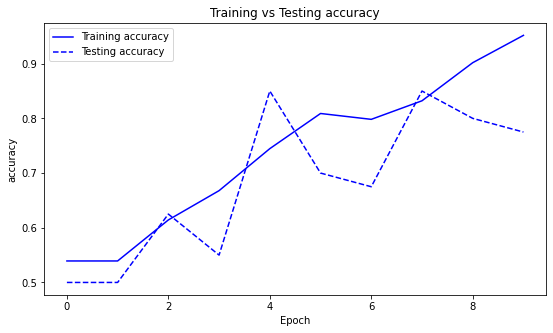

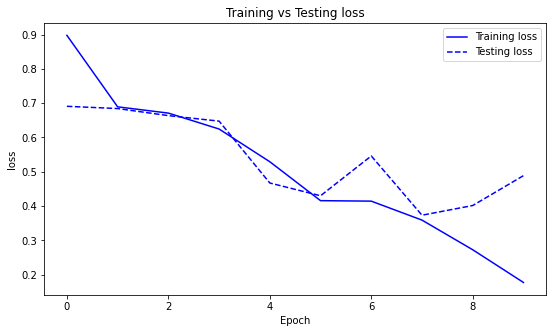

In [60]:
# Evaluate the accuracy and the loss function of the model

from matplotlib import pyplot as plt
def learning_curve(history, metrics):
  epochs = range(len(history.history[metrics]))

  plt.figure(figsize=(9, 5))
  plt.plot(epochs, history.history[metrics], "b-", label=f"Training {metrics}")
  plt.plot(epochs, history.history["val_" + metrics], "b--", label=f"Testing {metrics}")
  plt.xlabel("Epoch")
  plt.ylabel(f"{metrics}")
  plt.title(f"Training vs Testing {metrics}")
  plt.legend()
  plt.show()

learning_curve(history,'accuracy')
learning_curve(history,'loss')


#### Prediction

##### Save and load the model

In [67]:
#Save the model

from pathlib import Path
file_path=Path('image_model.h5')
model.save(file_path)

#Load the model

# import tensorflow as tf
# file_path=Path('image_model.h5')
# model_load=tf.keras.models.load_model(file_path)

##### Image Data Generator

In [63]:
def load_and_prep_image(filename, img_shape=180, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255
  else:
    return img

#### Prediction

In [69]:
import random
class_name='clean'
filename = random.choice(os.listdir("data/train/" + class_name))
filepath = "data/train/" + class_name+"/" + filename

img = tf.keras.utils.load_img(
    filepath, target_size=(180, 180)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 176ms/step
This image most likely belongs to clean with a 99.80 percent confidence.
